In [53]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

downloads = r"C:\Users\woofy\Downloads"
print("downloads contains:", os.listdir(downloads))

# build full path and load the ikea data with latin-1 encoding to handle special chars
file_path = os.path.join(downloads, "ikea_kommun_data.txt")
df = pd.read_csv(file_path, delimiter='\t', encoding='latin-1')
print("loaded data shape:", df.shape)


downloads contains: ['# Configuration options.py', '.Rhistory', '572.60-desktop-win10-win11-64bit-international-dch-whql.exe', 'AMI22T Assignment 1 task 2.R', 'AMI22T Home Exercise 1 (1).docx', 'AMI22T Home Exercise 1.docx', 'AMI22T Home Exercise 1.pdf', 'AMI22T_2022-05-30.pdf', 'AMI22T_2022-08-19.pdf', 'AMI22T_2023-05-30.pdf', 'AMI22T_2023-08-21.pdf', 'AMI22T_2024-05-27.pdf', 'AMI22T_2024-09-06.pdf', 'AMI22T_Formula_Sheet.docx', 'annotated-AMI29520Group20Project20v2.pdf', 'archive (1).zip', 'archive.zip', 'assignment 2 final#3.ipynb', 'Bachlor degree.pdf', 'Battle.net-Setup.exe', 'Bee Sad.png', 'better version#2.R', 'BI Project Notes (1).pdf', 'BI Project Notes.pdf', 'binance-setup.exe', 'BraveBrowserSetup-BRV011.exe', 'Business Intelligence handbook.pdf', 'cache-monkey-setup-1.0.7.exe', 'ChromeSetup.exe', 'City_Population__all_rows_.csv', 'ClassificationLab2.ipynb', 'clustering_test.ipynb', 'clustering_test.py', 'clusters.npy', 'correlation_matrix.csv', 'correlation_matrix_grade_only

In [54]:
# print basic info
print("initial data info:")
df.info()

# show first few rows
print("\nsample rows:")
print(df.head())

initial data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Kommun_code            207 non-null    int64  
 1   Year                   207 non-null    int64  
 2   Kommun_name            207 non-null    object 
 3   Revenue                207 non-null    int64  
 4   Employee               207 non-null    int64  
 5   Population             207 non-null    int64  
 6   Population_University  207 non-null    int64  
 7   Percent_University     207 non-null    float64
 8   Productivity           207 non-null    float64
 9   SalesIndex             207 non-null    float64
 10  Infrast                207 non-null    int64  
 11  Border                 207 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 19.5+ KB

sample rows:
   Kommun_code  Year     Kommun_name  Revenue  Employee  Population  \


In [55]:
# drop only the year column
df = df.drop(columns=['Year'])
# convert all except kommun_name to numeric
numeric_cols = df.columns.drop('Kommun_name')
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# check and drop any rows with missing numeric data
print("\nmissing per column:")
print(df[numeric_cols].isnull().sum())
df = df.dropna(subset=numeric_cols)
print("\ncleaned shape:", df.shape)



missing per column:
Kommun_code              0
Revenue                  0
Employee                 0
Population               0
Population_University    0
Percent_University       0
Productivity             0
SalesIndex               0
Infrast                  0
Border                   0
dtype: int64

cleaned shape: (207, 11)


here we remove the 'Year' column, which isnt useful for clustering

In [56]:
# see how many missing values per column
print("\nmissing per column:")
print(df.isnull().sum())

# drop rows with any missing data
df = df.dropna()

# final shape after cleaning
print("\ncleaned data shape:", df.shape)



missing per column:
Kommun_code              0
Kommun_name              0
Revenue                  0
Employee                 0
Population               0
Population_University    0
Percent_University       0
Productivity             0
SalesIndex               0
Infrast                  0
Border                   0
dtype: int64

cleaned data shape: (207, 11)


In [57]:
# drop both the id and the name before scaling
features = df.drop(columns=['Kommun_code', 'Kommun_name'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

print("scaled shape:", X_scaled.shape)



scaled shape: (207, 9)


In [58]:
# keep enough components to explain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("pca output shape:", X_pca.shape)
print("total variance explained:", pca.explained_variance_ratio_.sum())

pca output shape: (207, 5)
total variance explained: 0.9920352577426781


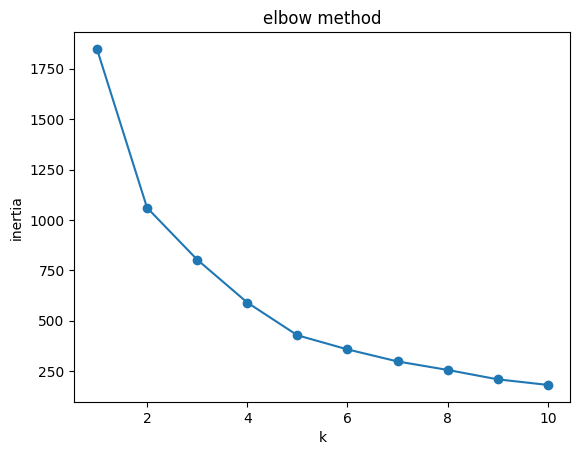

In [59]:
inertias = []
ks = range(1, 11)

for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('elbow method')
plt.show()


# this elbow plot helps choose the best number of clusters (k).
# it shows the inertia (total within-cluster distances) as we increase k.
# the 'elbow' around k=3 suggests that's a good choice—more clusters give only small improvements.


In [60]:
k = 3  # chosen from the elbow plot
km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
labels = km.fit_predict(X_pca)

# attach cluster labels to the original dataframe
df['cluster'] = labels

# see how many kommuner per cluster
print("count per cluster:")
print(df['cluster'].value_counts())


count per cluster:
cluster
0    177
2     29
1      1
Name: count, dtype: int64


In [61]:
# get average feature values for each cluster
# drop the id and name columns so mean only runs on numbers
summary = df.drop(columns=['Kommun_code', 'Kommun_name']) \
            .groupby('cluster') \
            .mean()

print("cluster summary (means):")
print(summary)


cluster summary (means):
              Revenue      Employee     Population  Population_University  \
cluster                                                                     
0          383.847458    211.118644   19891.514124            1898.355932   
1        32897.000000  18795.000000  847073.000000          191585.000000   
2         3887.758621   1796.758621   95952.137931           15070.620690   

         Percent_University  Productivity   SalesIndex   Infrast    Border  
cluster                                                                     
0                  0.086854     88.464811    39.551163  0.039548  0.045198  
1                  0.226173     87.717800  3389.665819  1.000000  0.000000  
2                  0.157762    109.827211   400.589796  0.068966  0.000000  


In [62]:
# mark which kommuner already have an ikea
existing = {
    "Borlänge","Gävle","Göteborg","Haparanda","Helsingborg",
    "Jönköping","Kalmar","Karlstad","Linköping","Malmö",
    "Stockholm","Sundsvall","Uddevalla","Umeå","Uppsala",
    "Västerås","Älmhult","Örebro"
}
df['has_ikea'] = df['Kommun_name'].isin(existing).astype(int)

# check
print(df['has_ikea'].value_counts(), "→ 1 means already has ikea")


has_ikea
0    195
1     12
Name: count, dtype: int64 → 1 means already has ikea


In [63]:
#pick top 3 candidates in cluster 2 (medium-sized)
candidates = (
    df[(df['cluster'] == 2) & (df['has_ikea'] == 0)]
    .sort_values('SalesIndex', ascending=False)
    .head(3)
)
print("top 3 new ikea candidates:")
print(candidates[['Kommun_name','Population','SalesIndex']])


top 3 new ikea candidates:
   Kommun_name  Population  SalesIndex
9     Huddinge       97453  737.036192
7     Järfälla       66211  527.455371
53  Norrköping      130050  457.285981


# here we filter to cluster 2 (the medium-sized municipalities) and exclude places that already have an ikea.
# then we sort by sales index, which reflects purchasing power, and pick the top 3 potential ikea locations.
# based on this, the best candidates are: huddinge, järfälla, and norrköping.


In [64]:
score = silhouette_score(X_pca, df['cluster'])
print("silhouette score:", score)

silhouette score: 0.4609157556895704


the silhouette score tells us how well-separated our clusters are, our score (~0.46) suggests a moderate but acceptable separation between the clusters

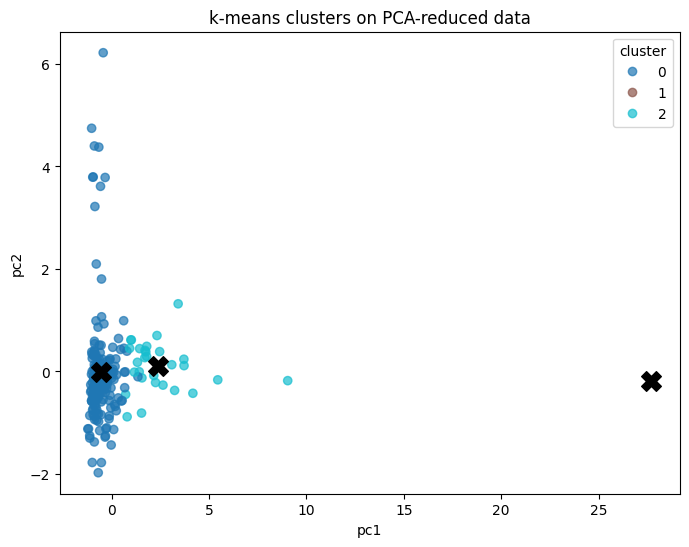

In [65]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=df['cluster'], cmap='tab10', alpha=0.7
)
# plot the centroids
centroids = km.cluster_centers_
plt.scatter(
    centroids[:,0], centroids[:,1],
    marker='X', s=200, c='black', label='centroids'
)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('k-means clusters on PCA-reduced data')
plt.legend(*scatter.legend_elements(), title="cluster")
plt.show()


# this scatter plot shows how the municipalities are clustered after reducing the data to 2 principal components.
# each color represents a cluster, and the black X marks are the k-means centroids.
# we can clearly see three separate groupings, with one large group on the left, a smaller spread group in the middle, and one outlier far to the right.


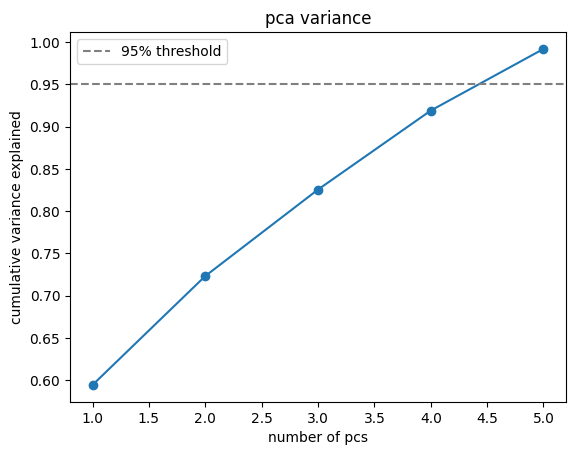

In [ ]:
#scree plot of pca explained variance
plt.plot(
    range(1, len(pca.explained_variance_ratio_)+1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.xlabel('number of pcs')
plt.ylabel('cumulative variance explained')
plt.title('pca variance')
plt.axhline(0.95, color='grey', linestyle='--', label='95% threshold')
plt.legend()
plt.show()


# this plot shows how much total variance is explained as we add more principal components.
# we can see that the first 5 pcs explain over 99% of the variance, which confirms that using pca with n_components=0.95 keeps most of the original information.


after cleaning the data and removing non-numeric columns, i scaled all features to make them comparable. then i applied principal component analysis (pca) to reduce the number of dimensions while keeping over 99% of the variance.

using the elbow method and silhouette score, i picked k = 3 as the best number of clusters. the clustering revealed:
- cluster 0: small cities with low revenue and population
- cluster 1: a single outlier (very large city)
- cluster 2: medium-sized cities with strong economic indicators

i then filtered cluster 2 to find cites without an existing ikea and ranked them by sales index. the top 3 recommendations for new ikea locations are:

1 huddinge:   strong population and highest sales index
2 järfälla:  large population and good economic profile
3 norrköping:  high population and purchasing power

these are well placed medium sized areas with potential demand for a new ikea store.